# 밀집지역 위험 알림 AI 프로젝트

카메라에서 들어오는 영상에서 특정 면적안의 사람 인식 및 인원수 파악 
인원수와 면적을 이용하여 계산하여 밀집도 계산
밀집도 단계별 알림
알림 방법 : 화면 표시, 문자 전송
- 1단계(Normal) 
   - 일반 단계, 밀집도 0 ~ 3 / ㎡
- 2단계 (Caution) 
   - 일반 단계, 밀집도 3 ~ 5 / ㎡
- 3단계 (Warning)
   - 일반 단계, 밀집도 5 / ㎡ 이상
   
<img src='data/output.jpg'>

## Ultralytics YOLOv8 모델 

### 개요
YOLOv8 is the latest iteration in the YOLO series of real-time object detectors, offering cutting-edge performance in terms of accuracy and speed. Building upon the advancements of previous YOLO versions, YOLOv8 introduces new features and optimizations that make it an ideal choice for various object detection tasks in a wide range of applications.
<img src='https://github.com/ultralytics/docs/releases/download/0/yolov8-comparison-plots.avif'>

#### 주요 기능
Advanced Backbone and Neck Architectures: YOLOv8 employs state-of-the-art backbone and neck architectures, resulting in improved feature extraction and object detection performance.
앵커 프리 스플릿 Ultralytics 헤드: YOLOv8 앵커 프리 스플릿 Ultralytics 헤드를 채택하여 앵커 기반 접근 방식에 비해 더 나은 정확도와 효율적인 탐지 프로세스에 기여합니다.
최적화된 정확도-속도 트레이드오프: 정확도와 속도 간의 최적의 균형을 유지하는 데 중점을 둔 YOLOv8 은 다양한 애플리케이션 영역의 실시간 물체 감지 작업에 적합합니다.
다양한 사전 학습 모델: YOLOv8 에서는 다양한 작업 및 성능 요구 사항을 충족하는 다양한 사전 학습 모델을 제공하므로 특정 사용 사례에 적합한 모델을 쉽게 찾을 수 있습니다.

#### [COCO dataset 특징]
ImageNet dataset의 문제점을 해결하기 위해 2014년 제안되었습니다. COCO dataset은 다양한 특징은 다음과 같습니다.

 다양한 크기의 물체가 존재하며 높은 비율로 작은 물체들이 존재합니다. 
또한, 덜 iconic합니다. 즉, 이미지가 특정 카테고리에 명확하게 속해있지 않다는 의미입니다.
80개의 classes가 있습니다.
" person bicycle car motorcycle airoplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair sofa potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush " 

### Import Libraries

In [95]:
from ultralytics import YOLO
from pathlib import Path
import gradio as gr
from playsound import playsound
from PIL import Image
import os
import threading
import time
import cv2

### Converted Model

In [2]:
ov_model = Path("models/yolov8n_openvino_model/yolov8n.xml")
if ov_model.is_file():
    print("OpenVINO model already exists.")

else:
    # Load a YOLOv8n PyTorch model
    model = YOLO("models/yolov8n.pt")
    
    # Export the model
    model.export(format="openvino")  # creates 'yolov8n_openvino_model/'

OpenVINO model already exists.


### Load Model

In [98]:
det_model = YOLO("models/yolov8n_openvino_model", task = "detect")

#### Test Model

Loading models\yolov8n_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 C:\BrainAI\HelloBot_test_yolov8n-WIP\data\coco_bike.jpg: 640x640 2 bicycles, 2 cars, 1 dog, 63.6ms
Speed: 5.0ms preprocess, 63.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skat

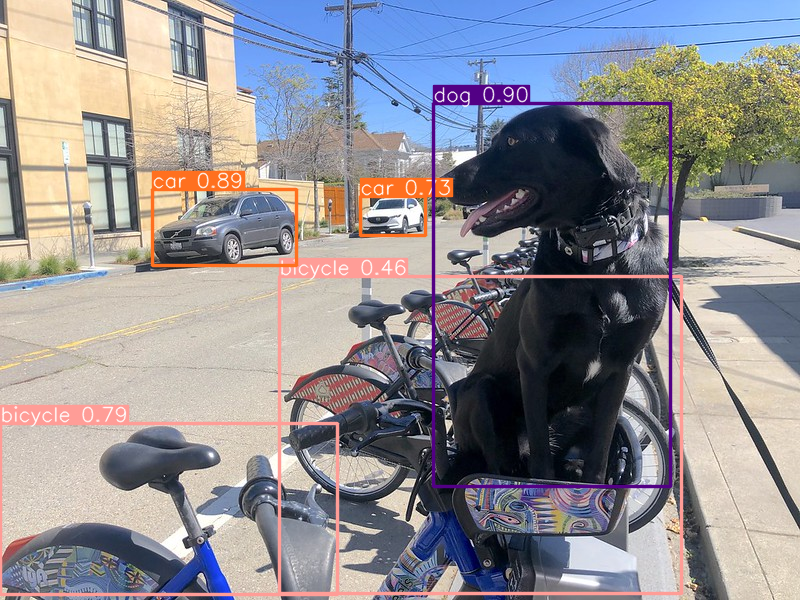

In [99]:
results = det_model("./data/coco_bike.jpg")
print(results)
if 0 in results[0].boxes.cls:
    print ("Person Detected")
    print( results[0].boxes.cls)

else:
    print("No Person Detected")
    
Image.fromarray(results[0].plot()[:, :, ::-1])

# Deployment

In [57]:
def infer_rectangle(frame):
    """
    입력된 프레임에서 65% 크기의 사각형을 중앙에 그리는 함수
    :param frame: 영상 프레임 (numpy 배열)
    :return: 사각형이 그려진 프레임
    """
    # 프레임의 너비와 높이 가져오기
    height, width, _ = frame.shape
    
    # 사각형 크기 65%로 설정
    rect_width = int(width * 0.65)
    rect_height = int(height * 0.65)
    
    # 사각형이 중앙에 위치하도록 좌상단과 우하단 좌표 계산
    start_point = (
        (width - rect_width) // 2,  # 좌상단 x 좌표
        (height - rect_height) // 2  # 좌상단 y 좌표
    )
    end_point = (
        start_point[0] + rect_width,  # 우하단 x 좌표
        start_point[1] + rect_height  # 우하단 y 좌표
    )
    
    # 사각형의 색상 (초록색: BGR 형식)
    color = (0, 255, 0)
    
    # 사각형의 두께 (2 픽셀)
    thickness = 2
       
    return start_point, end_point

In [58]:
def is_person_in_zone(box, zone):
    """
    사람의 바운딩 박스가 특정 영역에 들어왔는지 확인하는 함수
    :param box: YOLO 탐지 결과에서의 바운딩 박스 (좌상단 x, y, 우하단 x, y)
    :param zone: 특정 영역 (좌상단 x, y, 우하단 x, y)
    :return: 사람의 바운딩 박스가 영역에 들어오면 True, 아니면 False
    """
    box_x1, box_y1, box_x2, box_y2 = box
    zone_x1, zone_y1, zone_x2, zone_y2 = zone

    # 바운딩 박스의 중심 좌표 계산
    box_center_x = (box_x1 + box_x2) // 2
    box_center_y = (box_y1 + box_y2) // 2

    # 바운딩 박스의 중심이 특정 영역 안에 있는지 확인
    return (zone_x1 <= box_center_x <= zone_x2) and (zone_y1 <= box_center_y <= zone_y2)

In [67]:
def Hum_Density_display(num_people):
    human_density = round(num_people / 4 , 1)    #밀집도 계산, Area Size 4m2
    #print(human_density)
    density = str(human_density)
    
    if human_density > 3 and human_density < 5 :
        color = (0, 255, 255)
        text_val = 'Caution'
    elif human_density >=5 :
        color = (0, 0, 255)
        text_val = 'Warning'
    else :
        color = (0, 255, 0)
        text_val = 'Normal'
        
    return density, color, text_val

### Video

In [87]:
# 전체 화면 설정
def Main():

    camera = cv2.VideoCapture(source)
      
    while(True):
        ret, frame = camera.read()
    
        if not ret:
            break
        
        results = det_model(frame, verbose=False, conf = conf_threshold)
        
        zone_start_point, zone_end_point = infer_rectangle(frame) 
        
        person_num = len(results[0].boxes)       #감지된 사람 인원수 저장
        
        density_value, density_color, text_val = Hum_Density_display(person_num)
        
        # 탐지된 객체들 중 'person'만 처리
        for result in results:
            for box in result.boxes:
                if box.cls == 0:  # 클래스 0은 사람 (person) 클래스
                    # 바운딩 박스 좌표 가져오기
                    box_x1, box_y1, box_x2, box_y2 = map(int, box.xyxy[0])
                
                    # 사람의 바운딩 박스가 특정 영역에 들어왔는지 확인
                    if is_person_in_zone([box_x1, box_y1, box_x2, box_y2], [zone_start_point[0], zone_start_point[1], zone_end_point[0], zone_end_point[1]]):
                        # 박스를 특정 영역 안에 있는 경우만 그리기
                        cv2.rectangle(frame, (box_x1, box_y1), (box_x2, box_y2), (0, 255, 0), 2)
                        cv2.putText(frame, 'Person', (box_x1, box_y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)   
        
        # 특정 영역 표시
        overlay_image = cv2.imread('data/value.jpg')
        resized_overlay = cv2.resize(overlay_image, (100,100))
        
        frame[zone_start_point[1]:zone_start_point[1]+100, zone_end_point[0]:zone_end_point[0]+100] = resized_overlay
        
        cv2.rectangle(frame, (zone_start_point[0], zone_start_point[1]), (zone_end_point[0], zone_end_point[1]), density_color, 2)
        cv2.putText(frame, str(person_num) + " people detected, Area Size 4m2, Human Density : " + density_value, (zone_start_point[0], zone_start_point[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, density_color, 2)   
        cv2.putText(frame, text_val, (zone_start_point[0]+10, zone_start_point[1] + 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, density_color, 3)   
        
        cv2.imshow('Frame with Person Detection in Zone', frame)
    
        if cv2.waitKey(1) & 0xFF == ord(' '):  # 스페이스 바가 감지되면 중지
            break
    
    camera.release()
    cv2.destroyAllWindows()

In [88]:
#source =  0
source =  'data./people.mp4'

conf_threshold = .3

if __name__ == '__main__':
    Main()